In [8]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np

from skimage import measure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


In [2]:
filename = 'log_train.txt'

In [13]:
def extract_perf(filename):
    train_mean_loss = []

    with open(filename) as fin:
        for line in fin:
            if "mean loss" != line[:9]:
                continue
            items = line.rstrip().split(':')
            loss = float(items[1])
            train_mean_loss.append(loss)
            
    train_acc = []

    with open(filename) as fin:
        for line in fin:
            if "accuracy" != line[:8]:
                continue
            items = line.rstrip().split(':')
            acc = float(items[1])
            train_acc.append(acc)
            
    test_mean_loss = []

    with open(filename) as fin:
        for line in fin:
            if "eval mean loss" != line[:14]:
                continue
            items = line.rstrip().split(':')
            loss = float(items[1])
            test_mean_loss.append(loss)
            
    test_acc = []

    with open(filename) as fin:
        for line in fin:
            if "eval accuracy" != line[:13]:
                continue
            items = line.rstrip().split(':')
            acc = float(items[1])
            test_acc.append(acc)
            
    return np.array(train_mean_loss), np.array(train_acc), np.array(test_mean_loss), np.array(test_acc)

In [88]:
# collect acc vs num_pnts

num_pnts_list = [8, 16, 32, 64, 128, 256, 512, 1024, 2048]

train_accs = []
test_accs = []
test_best_idxs = []

for num_pnts in num_pnts_list:
    filename = "log/log_train_my_model_{}_.txt".format(num_pnts)
    a,b,c,d = extract_perf(filename)
    train_accs.append(b.max())
    test_accs.append(d.max())
    test_best_idxs.append(d.argmax())


In [51]:
test_best_idxs

[84, 76, 97, 91, 90, 88, 83, 63]

In [54]:
test_accs

[0.62621800000000005,
 0.77110400000000001,
 0.82792200000000005,
 0.86728899999999998,
 0.871753,
 0.88311700000000004,
 0.88352299999999995,
 0.88433399999999995]

### Prediction commands

python pointnet.py --model-path-file my_model_1024-80 --num_points 8 
python pointnet.py --model-path-file my_model_1024-80 --num_points 16
python pointnet.py --model-path-file my_model_1024-80 --num_points 32
python pointnet.py --model-path-file my_model_1024-80 --num_points 64
python pointnet.py --model-path-file my_model_1024-80 --num_points 128
python pointnet.py --model-path-file my_model_1024-80 --num_points 256
python pointnet.py --model-path-file my_model_1024-80 --num_points 512
python pointnet.py --model-path-file my_model_1024-80 --num_points 1024
python pointnet.py --model-path-file my_model_1024-80 --num_points 2048

python pointnet.py --model-path-file my_model_256-90 --num_points 8 
python pointnet.py --model-path-file my_model_256-90 --num_points 16
python pointnet.py --model-path-file my_model_256-90 --num_points 32
python pointnet.py --model-path-file my_model_256-90 --num_points 64
python pointnet.py --model-path-file my_model_256-90 --num_points 128
python pointnet.py --model-path-file my_model_256-90 --num_points 256
python pointnet.py --model-path-file my_model_256-90 --num_points 512
python pointnet.py --model-path-file my_model_256-90 --num_points 1024
python pointnet.py --model-path-file my_model_256-90 --num_points 2048


In [87]:
test_accs_by_1024 = [0.040179, 0.144886, 0.301136, 0.538961, 0.740666, 0.845373, 0.870130, 0.882305, 0.875812]
test_accs_by_256 = [0.035308,  0.117695, 0.275974,  0.599432, 0.816558, 0.879870, 0.879870, 0.872159, 0.866071]

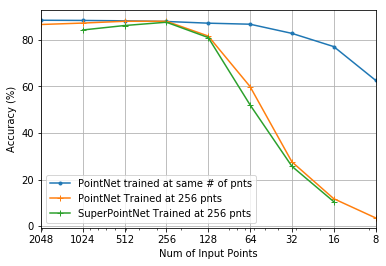

In [103]:
fig = plt.figure(figsize=(6,4))

# plt.semilogx(num_pnts_list, np.array(train_accs)*100, '.-')
plt.semilogx(num_pnts_list, np.array(test_accs)*100, '.-')
# plt.semilogx(num_pnts_list, np.array(test_accs_by_1024)*100, 'x-')
plt.semilogx(num_pnts_list, np.array(test_accs_by_256)*100, '+-')
plt.semilogx(spnt_num_pnts_list, np.array(test_accs_by_spnt_256)*100, '+-')
plt.grid()
plt.xlabel("Num of Input Points")
plt.ylabel("Accuracy (%)")
plt.xlim((num_pnts_list[-1], num_pnts_list[0]))
plt.xticks( num_pnts_list, num_pnts_list )
plt.legend(["PointNet trained at same # of pnts", "PointNet Trained at 256 pnts", "SuperPointNet Trained at 256 pnts"])

plt.show()
fig.savefig("acc_vs_num_points.pdf", bbox_inches='tight')


## SuperPointNet


In [73]:
def plot_loss_acc(num_epochs, train_mean_loss, train_acc, test_mean_loss, test_acc):
    fig = plt.figure(figsize=(12,5))
    train_x = np.arange(0.2, num_epochs+.2, 0.2)
    test_x = np.arange(1, num_epochs+.2, 1)
    
    ax = fig.add_subplot(2,1,1)

    ax.plot(train_x, train_mean_loss, '.', markersize=0.4)
    ax.plot(test_x, test_mean_loss, 'x', markersize=2)

    ax.set_ylabel("Mean Loss")
    ax.set_xlim((1,250))
    ax.set_ylim((0,2))
    ax.grid(True)
    ax.legend(["train", "test"])

    ax2 = fig.add_subplot(2,1,2, sharex=ax)

    ax2.plot(train_x, np.array(train_acc)*100, '.', markersize=0.4)
    ax2.plot(test_x, np.array(test_acc)*100, 'x', markersize=2)

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.grid(True)
    ax2.set_xlim((1,250))
    ax2.set_ylim((40,100))


    plt.setp(ax.get_xticklabels(), visible=False)

    plt.show()

    #fig.savefig("training_curves.pdf", bbox_inches='tight')

Best acc: 0.880276
Best model index: 210


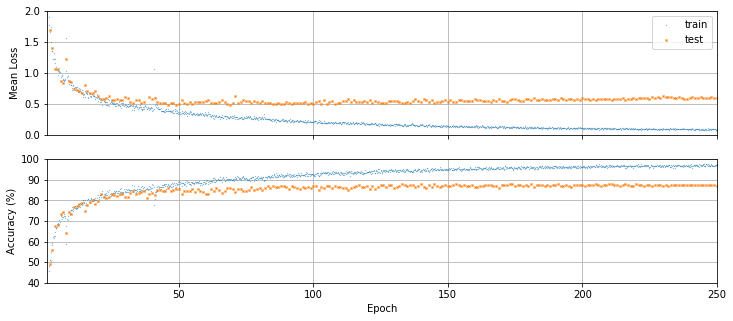

In [96]:



filename = "log/log_train_model_spnt_256_64_new_jitter.txt"
trloss, tracc, ttloss, ttacc = extract_perf(filename)

print("Best acc: {}".format(ttacc.max()))
print("Best model index: {}".format(ttacc.argmax()))

plot_loss_acc(500, trloss, tracc, ttloss, ttacc)

In [85]:
ttacc[150]

0.87581200000000003

Best acc: 0.877435
Best model index: 222


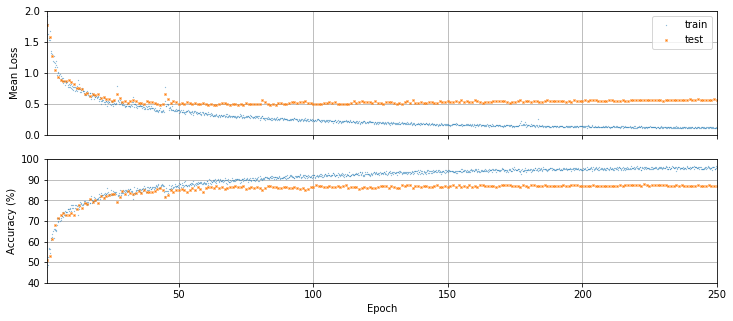

In [97]:

filename = "log/log_train_model_spnt_256_64_old_jitter.txt"
trloss, tracc, ttloss, ttacc = extract_perf(filename)

print("Best acc: {}".format(ttacc.max()))
print("Best model index: {}".format(ttacc.argmax()))
plot_loss_acc(250, trloss, tracc, ttloss, ttacc)

## Robustness to num of input points

python pointnet.py --model-path-file model_spnt_256_64_new-150 --num_points 256 --test test_files_.txt

python pointnet.py --model-path-file model_spnt_256_64_new-150 --num_points 128 --test test_files_128_32_gmm_inverse_std.txt

python pointnet.py --model-path-file model_spnt_256_64_new-150 --num_points 64 --test test_files_64_16_gmm_inverse_std.txt

python pointnet.py --model-path-file model_spnt_256_64_new-150 --num_points 32 --test test_files_32_8_gmm_inverse_std.txt

python pointnet.py --model-path-file model_spnt_256_64_new-150 --num_points 16 --test test_files_16_4_gmm_inverse_std.txt


In [91]:
spnt_num_pnts_list = [1024, 512, 256, 128, 64, 32, 16]
test_accs_by_spnt_256 = [0.842532, 0.861607, 0.875812,  0.810065, 0.520698, 0.256899, 0.105114]

In [ ]:
spnt_num_pnts_list = [1024, 512, 256, 128, 64, 32, 16]
test_accs_by_spnt_256 = [0.842532, 0.861607, 0.880276, 0.858031,  0.542614, 0.240260, 0.080763]

## Old below

In [25]:

train_x = np.arange(0.2, 250.2, 0.2)

test_x = np.arange(1, 250.2, 1)

In [24]:
train_x.shape

(1250,)

In [26]:
test_x.shape

(250,)

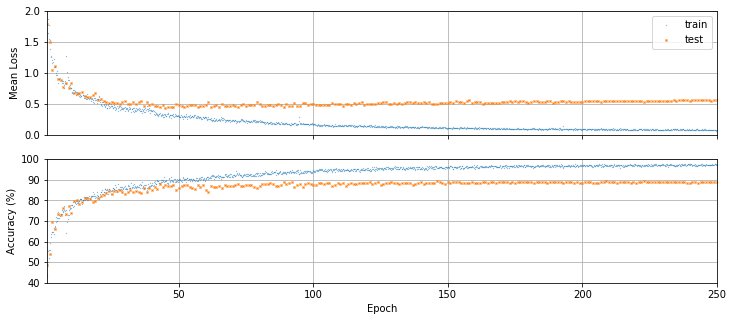

In [60]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(2,1,1)

ax.plot(train_x, train_mean_loss, '.', markersize=0.4)
ax.plot(test_x, test_mean_loss, 'x', markersize=2)

ax.set_ylabel("Mean Loss")
ax.set_xlim((1,250))
ax.set_ylim((0,2))
ax.grid(True)
ax.legend(["train", "test"])

ax2 = fig.add_subplot(2,1,2, sharex=ax)

ax2.plot(train_x, np.array(train_acc)*100, '.', markersize=0.4)
ax2.plot(test_x, np.array(test_acc)*100, 'x', markersize=2)

ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.grid(True)
ax2.set_xlim((1,250))
ax2.set_ylim((40,100))


plt.setp(ax.get_xticklabels(), visible=False)

plt.show()

fig.savefig("training_curves.pdf", bbox_inches='tight')

In [62]:
np.array(test_acc).max()

0.89488599999999996